## Import libs

In [2]:
from google.colab import auth
from google.cloud import bigquery

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Authenticated


## Autenticate with Google account

In [ ]:
auth.authenticate_user()
print('Authenticated')

project_id='data-science-portfolio-1'
client = bigquery.Client(project=project_id)

## Extract helper function

In [4]:
def sql_to_df(sql):
  # represent SQL query results as Pandas DataFrame
    return(client.query(sql).result().to_dataframe())


In [5]:
#table's schema
table = 'bigquery-public-data.usa_names.usa_1910_current'
client.get_table(table).schema

[SchemaField('state', 'STRING', 'NULLABLE', '2-digit state code', ()),
 SchemaField('gender', 'STRING', 'NULLABLE', 'Sex (M=male or F=female)', ()),
 SchemaField('year', 'INTEGER', 'NULLABLE', '4-digit year of birth', ()),
 SchemaField('name', 'STRING', 'NULLABLE', 'Given name of a person at birth', ()),
 SchemaField('number', 'INTEGER', 'NULLABLE', 'Number of occurrences of the name', ())]

## Popularity of name 'Weronika' and similar

In [31]:
qW = """
    SELECT
      name, sum(number)
    FROM
      `bigquery-public-data.usa_names.usa_1910_current`
    WHERE name LIKE 'Weroni%' OR name LIKE 'Veroni%' OR name LIKE 'Beroni%'
    GROUP BY name
    ORDER BY sum(number) DESC
    """

weronikas = sql_to_df(qW)
weronikas

,name,f0_
0,Veronica,214176
1,Veronika,1506
2,Beronica,451
3,Veronique,252
4,Weronika,128
5,Veronic,5


Text(0, 0.5, 'Total Number')

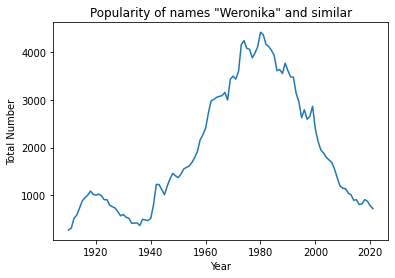

In [35]:
popularity_query = """
    SELECT 
      year, sum(total_number) as total
    FROM
      (SELECT
        year, name, sum(number) as total_number
      FROM
        `bigquery-public-data.usa_names.usa_1910_current`
      WHERE name LIKE 'Weroni%' OR name LIKE 'Veroni%' OR name LIKE 'Beroni%'
      GROUP BY year, name
      )
    GROUP BY year
    ORDER BY year ASC
    """

wer_graph = sql_to_df(popularity_query)
plt.plot(wer_graph.year, wer_graph.total, label = "Total")
plt.title('Popularity of names "Weronika" and similar')
plt.xlabel('Year')
plt.ylabel('Total Number')



##20 most popular female names

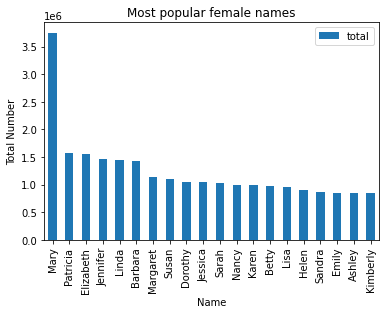

In [8]:
female = (
    """
    SELECT 
      name, sum(number) as total
    FROM
     `bigquery-public-data.usa_names.usa_1910_current`
    WHERE gender = 'F'
    GROUP BY name
    ORDER BY total DESC
    LIMIT 20
    """)

female_bar = sql_to_df(female)

female_bar.plot(kind='bar', x='name', y='total', xlabel = 'Name', ylabel = 'Total Number', title = 'Most popular female names')


## Most recent male names popularity trend

In [9]:
find_male = (
    """
    SELECT
        name, sum(number) as total_number
    FROM
        `bigquery-public-data.usa_names.usa_1910_current`
    WHERE gender = 'M' AND year=2021
    GROUP BY name
    ORDER BY total_number DESC
    LIMIT 5 

    """)

male_2021 = sql_to_df(find_male)
male_2021

,name,total_number
0,Liam,20272
1,Noah,18739
2,Oliver,14616
3,Elijah,12708
4,James,12367


In [10]:
rank_query = """
 WITH rank_table AS
    (SELECT 
    name, rnk 
    FROM
      (SELECT
        name, total_number,
      RANK() OVER(ORDER BY total_number DESC) as rnk
      FROM
        (SELECT
          name, sum(number) as total_number
        FROM
         `bigquery-public-data.usa_names.usa_1910_current` as table1
        WHERE gender = 'M' AND year=2021
        GROUP BY name
        ORDER BY total_number DESC
        LIMIT 5
        )
      ORDER BY rnk))
  SELECT
  table2.year,
  table2.name,
  sum(table2.number) as total_number,
  rank_table.rnk
  FROM       
  rank_table
  INNER JOIN `bigquery-public-data.usa_names.usa_1910_current` AS table2
  ON rank_table.name = table2.name
  WHERE year>2001 AND table2.gender = 'M'
  GROUP BY year, name, rnk
  ORDER BY year ASC, total_number DESC
  """
male_pop = sql_to_df(rank_query)
male_pop

,year,name,total_number,rnk
0,2002,James,16966,5
1,2002,Noah,12071,2
2,2002,Elijah,10052,4
3,2002,Liam,3375,1
4,2002,Oliver,1136,3
...,...,...,...,...
95,2021,Liam,20272,1
96,2021,Noah,18739,2
97,2021,Oliver,14616,3
98,2021,Elijah,12708,4


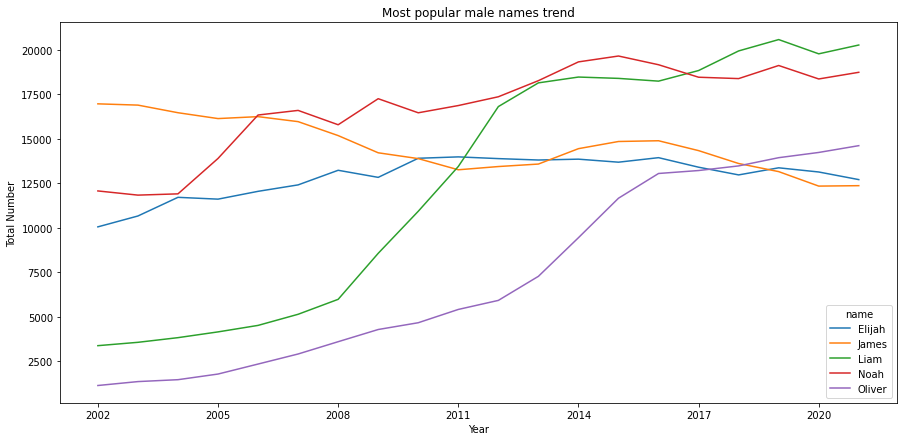

In [29]:
male_plot = pd.pivot_table(
    male_pop, values='total_number', index='year', columns='name')
male_plot.plot(xlabel='Year', ylabel='Total Number', title='Most popular male names trend', fontsize=10, figsize=(15,7), xticks=(np.arange(2002, 2021, step=3)))